In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
import sys

In [2]:
df = pd.read_csv("data/starsCYG.csv", sep=",", index_col="id")

In [3]:
df[:10]

,log.Te,log.light
id,,
1,4.37,5.23
2,4.56,5.74
3,4.26,4.93
4,4.56,5.74
5,4.30,5.19
6,4.46,5.46
7,3.84,4.65
8,4.57,5.27
9,4.26,5.57


In [20]:
logTe = df['log.Te'].values
logLight = df['log.light'].values
N = len(logTe)

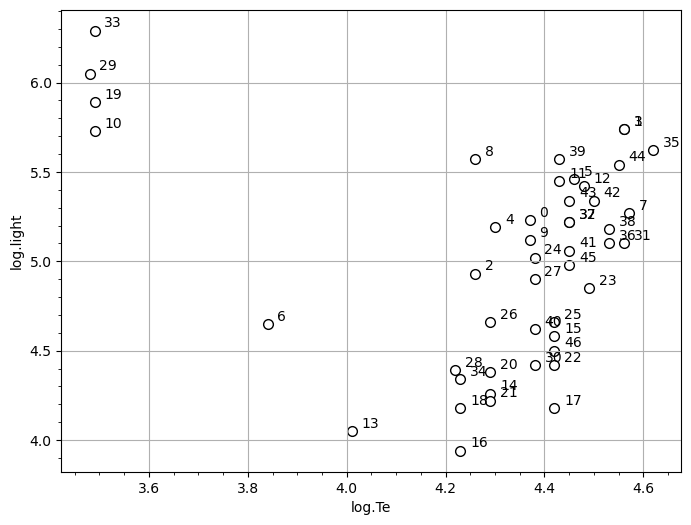

In [6]:
plt.figure(figsize=(8,6))
plt.scatter(logTe, logLight, c='w', edgecolors='k', s=49, linewidths=1.0)

for i, x, y in zip(range(len(logTe)), logTe, logLight):
    plt.text(x+0.02,y+0.02,str(i),)

plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.minorticks_on()
plt.grid(1)
plt.show()

$$
\rho(r)=\sqrt{\varepsilon^2+r^2} - \varepsilon
$$
$$
\rho'(r) = r/(\varepsilon^2+r^2)^{1/2}
$$
$$
\rho''(r) = \varepsilon^2/(\varepsilon^2+r^2)^{3/2}
$$

$$
\rho_\alpha(r) = \left\{
\begin{array}{ll}
\alpha\rho(r),&если\ r>0\\
(1-\alpha)\rho(r),&если\ r\leq0\\
\end{array}
\right.
$$

In [8]:
class RhoSqrt:
    #
    def __init__(self, eps):
        self.eps = eps
    #
    def evaluate(self, arr):
        eps = self.eps
        return np.sqrt(eps*eps + arr*arr) - eps
    #
    def derivative(self, arr):
        eps = self.eps
        v = np.sqrt(eps*eps + arr*arr)
        return arr / v
    #
    def varphi(self, arr): 
        eps = self.eps
        v = np.sqrt(eps*eps + arr*arr)
        return 1 / v
    #
    def derivative2(self, arr):
        eps = self.eps
        v = np.sqrt(eps*eps + arr*arr)
        return eps*eps / v**3

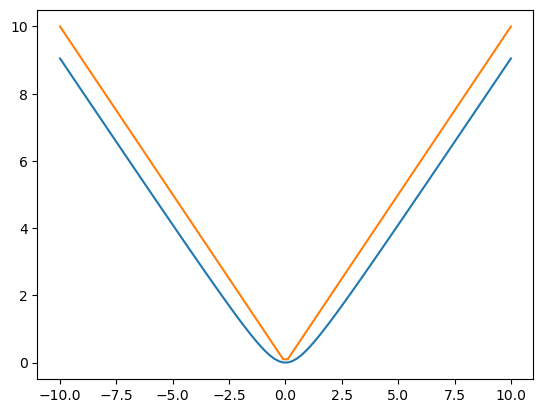

In [9]:
rho_sqrt = RhoSqrt(1.0)
xrange = np.linspace(-10.0, 10.0, 100)
yrange = rho_sqrt.evaluate(xrange)

plt.plot(xrange, yrange)
plt.plot(xrange, np.abs(xrange))
plt.show()

Штрафная функция:
$$
P(u) = \frac{1}{N}\sum_{k=1}^N \rho(z_k-u)
$$

Итерационная процедура для нахождения значения функции среднего:
$$
\mathsf{M}\{z_1,\dots,z_N\} = \arg\min_u \frac{1}{N}\sum_{k=1}^N \rho(z_k-u)
$$

$$
u_{t+1} = \frac{\sum\limits_{k=1}^N \varphi(z_k-u_t)z_k}{\sum\limits_{k=1}^N \varphi(z_k-u_t)}, \quad \varphi(r)=\rho'(r)/r
$$

In [8]:
# class Penalty:
#     #
#     def __init__(self, rho):
#         self.rho = rho
#     #
#     def __call__(self, X, u):
#         return np.sum(self.rho(X-u)) / len(X)
#     #
#     def derivative(self, X, u):
#         return -np.sum(self.rho.derivative(X-u)) / len(X)

In [10]:
class MAverage:
    #
    def __init__(self, rho, n_iter=1000, tol=1.0e-9):
        self.rho = rho
        # self.penalty = Penalty(rho)
        self.n_iter = n_iter
        self.tol = tol
    #
    # def penalty(self, X):
    #     return self.penalty(X, self.u)
    # #
    def evaluate(self, X):
        self.us = []
        # X = np.atleast_1d(X)
        u = np.mean(X)
        self.us.append(u)
        for K in range(self.n_iter):
            u_prev = u
            W = self.rho.varphi(X-u)
            u = (W @ X) / W.sum()
            self.us.append(u)

            if abs(u - u_prev) < self.tol:
                break

        self.K = K + 1
        self.u = u
        return u
    #
    def gradient(self, X):
        # X = np.atleast_1d(X)
        G = self.rho.derivative2(X - self.u)
        G /= G.sum()
        return G

### Принцип минимизации робастных средних квадратов ошибки

$$
w^* \in \arg\min_{\mathbf{w}} \mathsf{M}_\rho\{ (f(\mathbf{x}_1,\mathbf{w}_t)-y_1)^2, \dots, (f(\mathbf{x}_N,\mathbf{w}_t)-y_N)^2 \}
$$

$$
\nabla Q(w) = \sum_{k=1}^N \frac {\partial M_\rho\{z_1,\dots,z_N\}}{\partial z_k} \nabla (f(x_k;w)-y_k)^2,
$$
$z_k = (f(x_k;w)-y_k)^2$

### Метод итеративного перевзвешивания (IRLS)

$$
\mathbf{w}_{t+1} = \arg \min_{\mathbf{w}} \sum_{k=1}^N v_k (f(\mathbf{x}_k,\mathbf{w}_t)-y_k)^2
$$
где
$$
V = \nabla \mathsf{M}_\rho \{ (f(\mathbf{x}_1,\mathbf{w}_t)-y_1)^2, \dots, (f(\mathbf{x}_N,\mathbf{w}_t)-y_N)^2 \}
$$
$$
\frac{\partial\mathsf{M}_\rho\{ z_1,\dots, z_N\}}
     {\partial z_k}  = 
     \frac{\rho''(z_k-\bar z)}{\rho''(z_1-\bar z) + \cdots + \rho''(z_N-\bar z)}
$$

In [11]:
class IRLS:
    #
    def __init__(self, avrfunc, tol=1.0e-3, n_iter=200):
        self.avrfunc = avrfunc
        self.tol = tol
        self.n_iter = n_iter
        self.K = 0
    #
    def fit(self, X, Y):
        e = e_min = sys.float_info.max

        self.evals = []
        sample_weight = None

        for K in range(self.n_iter):
            e_prev = e

            rg = linear_model.LinearRegression()
            rg.fit(X, Y, sample_weight=sample_weight)
            Yp = rg.predict(X)

            Err = (Y - Yp)**2
            e = self.avrfunc.evaluate(Err)
            self.evals.append(e)
            sample_weight = self.avrfunc.gradient(Err)

            if e < e_min:
                rg_min = rg
                e_min = e

            if np.abs(e - e_prev) < self.tol:
                break

        self.rg = rg_min
        self.e_min = e_min
        return rg_min


In [12]:
rho = RhoSqrt(0.001)
alg = IRLS(MAverage(rho))

0 0.09071392745625484


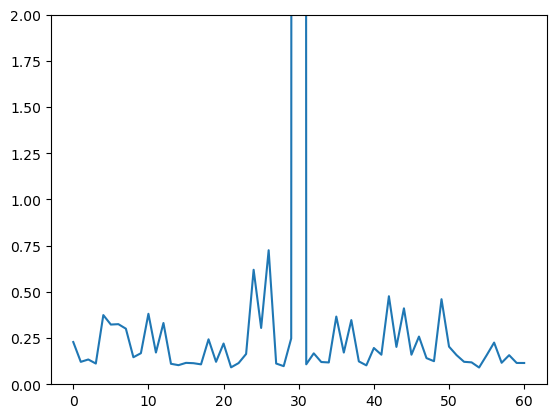

In [13]:
alg.fit(logTe[:,None], logLight)
print(alg.K, alg.e_min)

plt.plot(alg.evals)
plt.ylim(0,2)
plt.show()
# plt.plot(alg.avrfunc.us)
# plt.show()

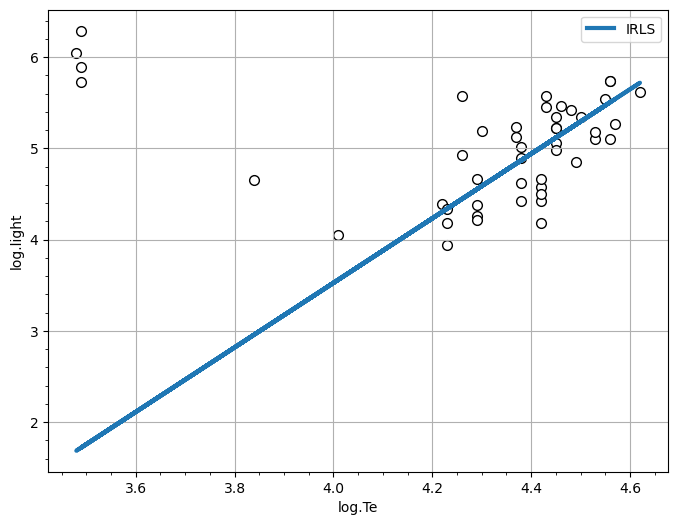

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(logTe, logLight, c='w', edgecolors='k', s=49, linewidths=1.0)
plt.plot(logTe, alg.rg.predict(logTe[:,None]), label='IRLS', linewidth=3)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.minorticks_on()
plt.grid(1)
plt.legend()
plt.show()

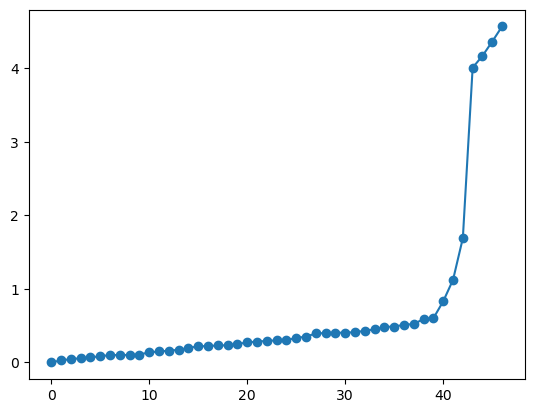

In [15]:
plt.plot(sorted(np.abs(logLight - alg.rg.predict(logTe[:,None]))), marker='o')
plt.show()

In [16]:
class QuantRho:
    #
    def __init__(self, rho, alpha=0.5):
        self.rho = rho
        self.alpha = alpha
    #
    def evaluate(self, X):
        y = self.rho.evaluate(X)
        A = np.zeros_like(X)
        np.putmask(A, X > 0, self.alpha)
        np.putmask(A, X < 0, 1-self.alpha)
        return A * y
    #
    def varphi(self, X):
        y = self.rho.varphi(X)
        A = np.zeros_like(X)
        np.putmask(A, X > 0, self.alpha)
        np.putmask(A, X < 0, 1-self.alpha)
        return A * y
    #
    def derivative2(self, X):
        y = self.rho.derivative2(X)
        A = np.zeros_like(X)
        np.putmask(A, X > 0, self.alpha)
        np.putmask(A, X < 0, 1-self.alpha)
        return A * y
    #
        

In [32]:
class WMAverage:
    #
    def __init__(self, rho):
        self.rho = rho
        self.avrfunc = MAverage(rho)
    #
    def evaluate(self, X):
        self.u = u = self.avrfunc.evaluate(X)
        Y = X.copy()
        np.putmask(Y, X >= u, u)
        return np.mean(Y)
    #
    def gradient(self, X):
        u = self.u
        m = (X >= u).sum()
        g = m * self.avrfunc.gradient(X)
        np.putmask(g, X < u, g+1)
        return g / len(X)

In [51]:
alpha = (N - 6) / N
print(alpha)
rho = QuantRho(RhoSqrt(0.001), 0.8)
alg2 = IRLS(WMAverage(rho))

0.8723404255319149


0 0.1208284832679082


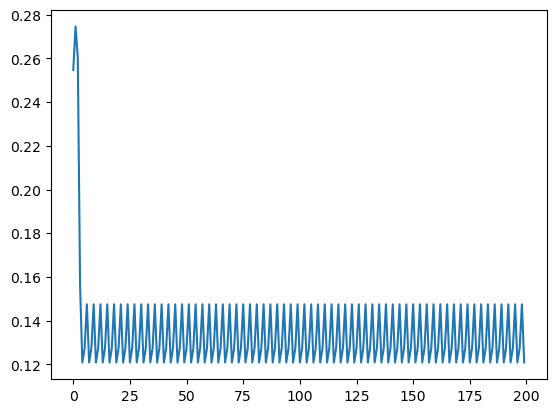

In [52]:
alg2.fit(logTe[:,None], logLight)
print(alg2.K, alg2.e_min)

plt.plot(alg2.evals)
plt.show()

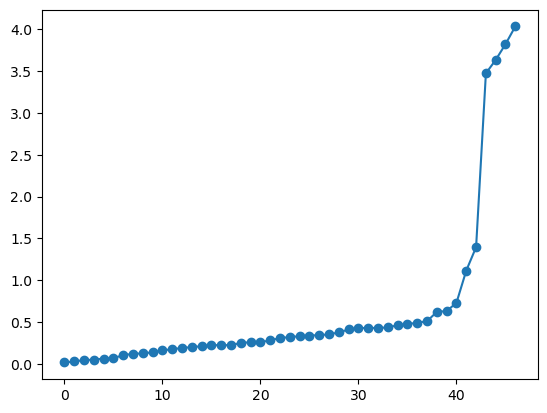

In [53]:
plt.plot(sorted(np.abs(logLight - alg2.rg.predict(logTe[:,None]))), marker='o')
plt.show()

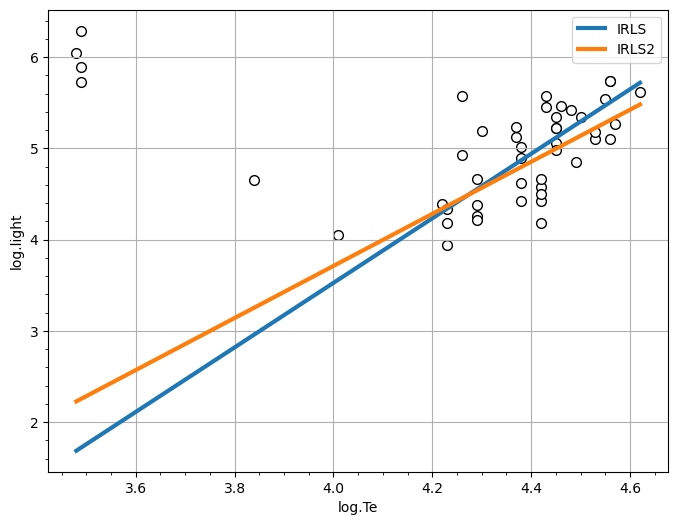

In [54]:
plt.figure(figsize=(8,6))
plt.scatter(logTe, logLight, c='w', edgecolors='k', s=49, linewidths=1.0)
xrange = np.linspace(logTe.min(), logTe.max(), 3)
plt.plot(xrange, alg.rg.predict(xrange[:,None]), label='IRLS', linewidth=3)
plt.plot(xrange, alg2.rg.predict(xrange[:,None]), label='IRLS2', linewidth=3)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.minorticks_on()
plt.grid(1)
plt.legend()
plt.show()

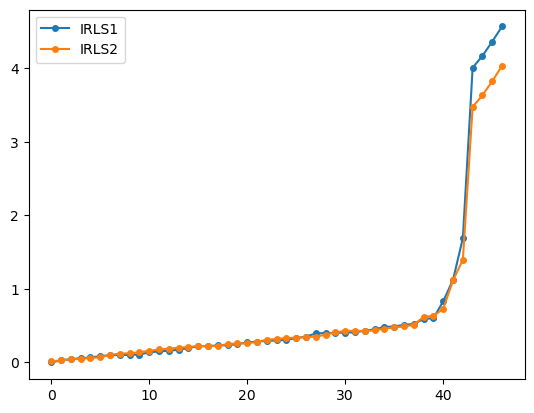

In [57]:
plt.plot(sorted(np.abs(logLight - alg.rg.predict(logTe[:,None]))), 
         marker='o', markersize='4', label='IRLS1')
plt.plot(sorted(np.abs(logLight - alg2.rg.predict(logTe[:,None]))), 
         marker='o', markersize='4', label='IRLS2')
plt.legend()
plt.show()